<a href="https://colab.research.google.com/github/jaydigy/jayg_colab_gate/blob/main/ak_makemore_pt3_by_jayg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
!wget "https://raw.githubusercontent.com/jaydigy/jayg_colab_gate/main/names.txt"

--2023-05-15 15:11:55--  https://raw.githubusercontent.com/jaydigy/jayg_colab_gate/main/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2023-05-15 15:11:55 (50.4 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
#read all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
#build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
#build the dataset
block_size = 3 #context length : how many chracters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        #80%
Xdev, Ydev = build_dataset(words[n1:n2])    #10%
Xte, Yte = build_dataset(words[n2:])        #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
#MLP revisited
n_embd = 10 #the dimensinaliity of the character embedding vectors
n_hidden = 200 # the number of the neuron in the hidden layer of mlp

g = torch.Generator().manual_seed(214783647) # for reproducibility
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5) # * 0.2 의 토치 kaiser normal 기능구현함
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0.01

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True    

11897


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y

    # forward pass
    emb = C[Xb] #embded the characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print every once in a while 
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break


      0/ 200000 : 3.2923


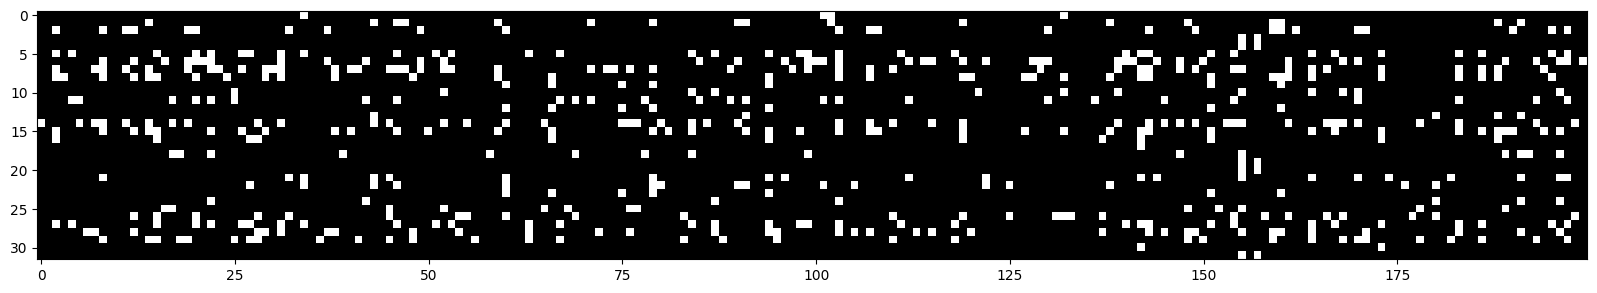

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([668., 297., 206., 190., 153., 169., 153., 121.,  84., 105.,  91.,
         91.,  92., 116., 121.,  84.,  68.,  82.,  85.,  68.,  73.,  73.,
         50.,  60.,  53.,  68.,  75.,  83.,  78.,  78.,  70.,  76.,  78.,
         74.,  80.,  83.,  85.,  75.,  80.,  92.,  73.,  81.,  99., 130.,
        136., 149., 165., 167., 264., 608.]),
 array([-9.99995947e-01, -9.59996327e-01, -9.19996707e-01, -8.79997088e-01,
        -8.39997468e-01, -7.99997848e-01, -7.59998229e-01, -7.19998609e-01,
        -6.79998989e-01, -6.39999369e-01, -5.99999750e-01, -5.60000130e-01,
        -5.20000510e-01, -4.80000890e-01, -4.40001271e-01, -4.00001651e-01,
        -3.60002031e-01, -3.20002412e-01, -2.80002792e-01, -2.40003172e-01,
        -2.00003552e-01, -1.60003933e-01, -1.20004313e-01, -8.00046933e-02,
        -4.00050735e-02, -5.45382500e-06,  3.99941659e-02,  7.99937856e-02,
         1.19993405e-01,  1.59993025e-01,  1.99992645e-01,  2.39992265e-01,
         2.79991884e-01,  3.19991504e-01,  3.59991

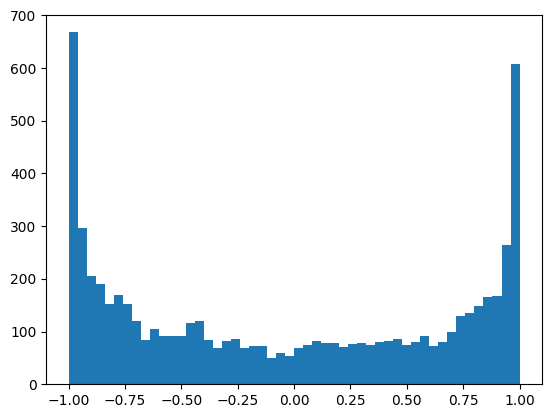

In [ ]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   1.,   3.,   3.,   5.,   2.,   2.,   2.,   4.,  27.,  16.,
         25.,  41.,  40.,  55.,  92., 104., 142., 191., 228., 246., 321.,
        410., 367., 491., 423., 444., 423., 379., 306., 347., 252., 202.,
        181., 135., 129.,  83.,  73.,  58.,  34.,  29.,  23.,  25.,   9.,
          9.,   2.,   3.,   3.,   7.,   2.]),
 array([-6.55508232, -6.30593041, -6.05677851, -5.8076266 , -5.55847469,
        -5.30932279, -5.06017088, -4.81101897, -4.56186707, -4.31271516,
        -4.06356325, -3.81441134, -3.56525944, -3.31610753, -3.06695562,
        -2.81780372, -2.56865181, -2.3194999 , -2.070348  , -1.82119609,
        -1.57204418, -1.32289227, -1.07374037, -0.82458846, -0.57543655,
        -0.32628465, -0.07713274,  0.17201917,  0.42117107,  0.67032298,
         0.91947489,  1.16862679,  1.4177787 ,  1.66693061,  1.91608252,
         2.16523442,  2.41438633,  2.66353824,  2.91269014,  3.16184205,
         3.41099396,  3.66014586,  3.90929777,  4.15844968,  4.40760159,
 

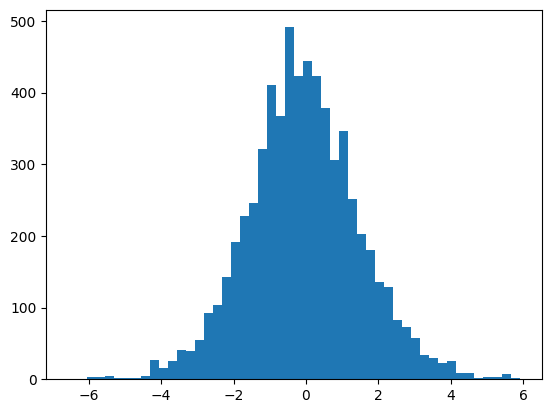

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50)

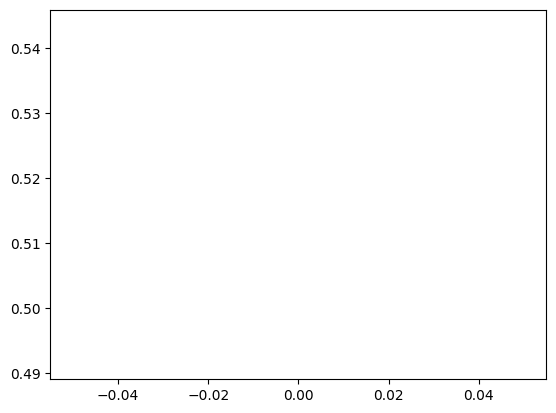

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() #  this decorator disables gradient tracking
def split_loss(split):
    X, Y = {
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte) 
    }[split]
    emb = C[X] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())

split_loss('train')
split_loss('val') 

train 3.1976211071014404
val 3.1938869953155518


# Loss Log

1. original
train : 2.12
val : 2.16

2. fix softmax confidently wrong:
train 2,07
val : 2.13

3. fix tanh layer too saturated at init:
train : 2.03
val : 2.1

4. add batch norm layer:
train : 2.0668
val : 2.14


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20) :

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, e_embd)
        h= torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' tokem, break
        if ix == 0 :
            break
    print(''.join(itos[i] for i in out)) # decode and print the generated word


mrqujgmyazzhzevvndhfyalwqetvrsjejdrlrg.
azcjedgeliihsmpqppalekepxvqnwxarveptzcmhvqepcn.
szdbvrgxhgmjest.
jcjrwjljqqxntpucfkubzkgvdtrxyqqufzehg.
kmejqvskkydmzhjl.
cakyybsufxzbjglvjurenjcrtvwsvevoecmpfhdxjfqyxoeobhggptixjsfcueywhkhmrjolbii.
qiif.
evpkxwvlla.
ortabfsztjnegoiztsblitgfkxvbsfivpu.
meewrkepxcmvyhxavttuhkjgczekhgkgtimvtudt.
iwbddjhzvorlq.
cjakepxugniagcrpppfmiipzjgvonxet.
jydnblknkzporygnogsimwosfz.
bskknvmjcxtxncjbmu.
etew.
amc.
copmrlxkzdcqbcep.
ccafivsnicimhtacmos.
gouwzlrurdckappomtcokwxtnbnzkdphfam.
xcojfffuncxzhosynsj.


In [ ]:
# 초기 시작의 확률 예측치는 27개의 글자가 다음에 올 확률이 모두 동일다면 1/27 이므로,
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [ ]:
# 4-dimensional example of the issue
logits = torch.tensor([1.0, 1.0, 1.0, 1.0])
probs = torch.softmax(logits, dim=0)
#probs = logits / logits.sum()
loss = -probs[2].log()
probs, probs[2], loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(0.2500), tensor(1.3863))

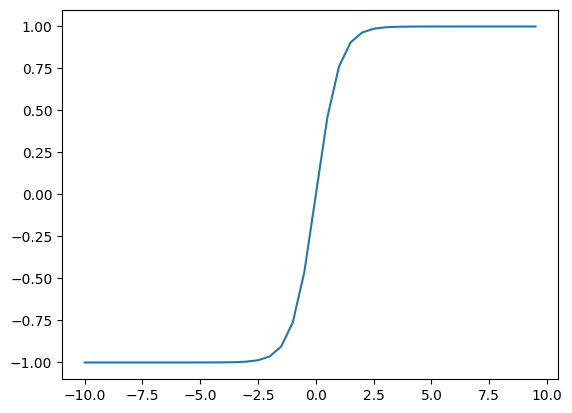

In [ ]:
x = torch.arange(-10, 10, 0.5)
y = x.tanh()
plt.plot(x, y)

In [ ]:
(torch.randn(10000)*0.2).std()

tensor(0.1982)

tensor(0.0141) tensor(0.9945)
tensor(-0.0023) tensor(0.9944)


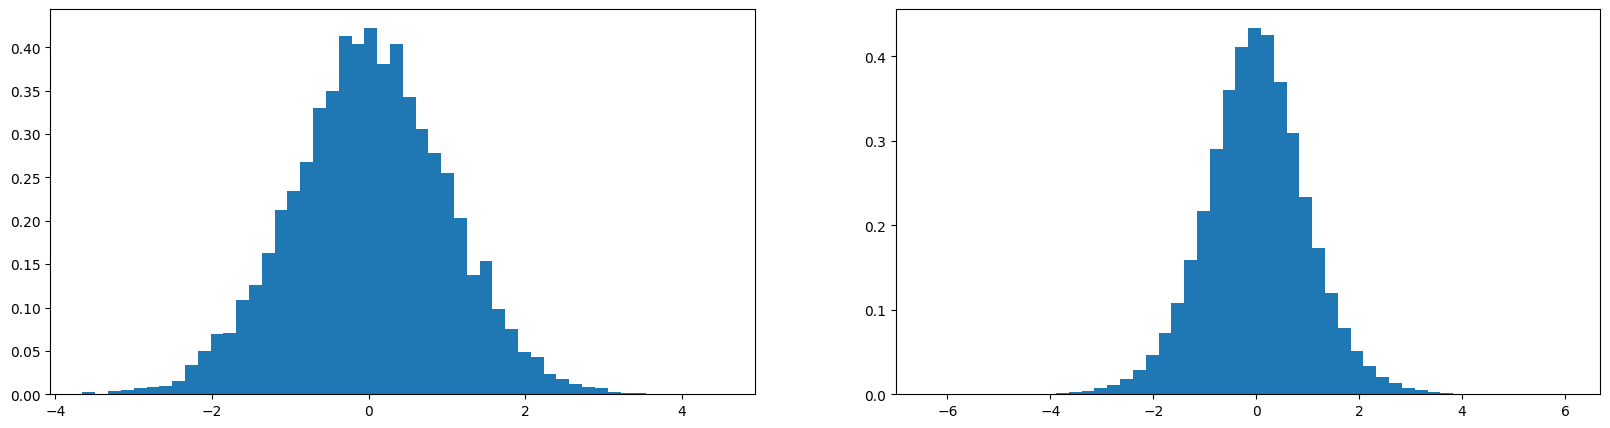

In [ ]:
x = torch.randn(1000, 10) # 1000개의 데이터가 10개의 뉴런으로 들어감
w = torch.randn(10, 200) / 10**0.5 # 10개의 데이터가 200개의 뉴런으로 들어감 -> 가우시안 범위가 너무 넓어져서, x같은 분포가 나오게 하는게 좋음 
y = x @ w # squre root of 10 (x의 뉴런 개수)로 w를 나누어 주면 x와 w의 가우시안 분포가 비슷해진다. -> torch.nn.ini.kaiming_normail_ 명령어가 이 효과를 내는 토치 함수임
# 오늘날 기술이 발전하면서 초기값 세팅의 한계를 극복하는 기술이 많이 나왔으며,
# 경사하강법 대비 rmsprop, adam 사용, residual correction, batch norm, layer norm 사용되면서 초기 세팅이 덜 중요해짐.
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);


In [ ]:
# barch normalization 유투브 41:00

In [ ]:
#MLP revisited
n_embd = 10 #the dimensinaliity of the character embedding vectors
n_hidden = 200 # the number of the neuron in the hidden layer of mlp

g = torch.Generator().manual_seed(214783647) # for reproducibility
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5) # * 0.2 의 토치 kaiser normal 기능구현함
# b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0.01

#BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True    

12297


In [ ]:
hpreact.shape

torch.Size([32, 200])

In [ ]:
hpreact.mean(0, keepdims=True).shape

torch.Size([1, 200])

In [ ]:
hpreact.std(0, keepdims=True).shape

torch.Size([1, 200])

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y

    # forward pass
    emb = C[Xb] #embded the characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    # linear layer (convolution layer -> 파이토치 매뉴얼 nn의 linear 참조
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    # BatchNorm layer
    # ----------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi +bnbias
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdims=True))/hpreact.std(0, keepdims=True) +bnbias #hidden layer pre-activation
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999* bnstd_running + 0.001 * bnstdi
    # -----------------------------------------------------------
    # non-linearity
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print every once in a while 
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break


      0/ 200000 : 3.3037


In [ ]:
# # calibrate the batch norm at the end of training  -> optimization 코드에 녹였음

# with torch.no_grad():
#     # pass te training set through
#     emb = C[Xtr]
#     emcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 #+ b1
#     #measure the mean/std over the entire training set
#     bnmean = hpreact.mean(0, keepdim=True)
#     bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() #  this decorator disables gradient tracking
def split_loss(split):
    X, Y = {
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte) 
    }[split]
    emb = C[X] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdims=True))/hpreact.std(0, keepdims=True) +bnbias #hidden layer pre-activation
    hpreact = bngain * (hpreact - bnmeani) / bnstdi +bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())

split_loss('train')
split_loss('val') 

train 3.2896344661712646
val 3.2891993522644043


다음 강의  -> 유투브 1:18:00 --> summary 코드를 보여줌


In [ ]:
# summary ---------------

In [ ]:
# let's train a deeper network

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] +([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calcuate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)         #batch mean
            xvar = x.var(0, keepdim=True, unbiased=True)           #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        #update the biffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return[self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the chracter embedding vectors
n_hidden = 100 # the number of the neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),           generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    #Linear(           n_hidden, n_hidden), Tanh(),
    #Linear(           n_hidden, n_hidden), Tanh(),
    #Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    #last layer make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers : apply again
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [ p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters :
    p.requires_grad = True

47024


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # Forward Pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers : 
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers :
        layer.out.retain_grad() # After_Debug : wolud take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters :
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0 : # print every once in a while
        print(f'{i:7d} / {max_steps:7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    #if i >= 1000:
    #    break # adter debug : wold take out obviously to run full optimization



        

      0 /  200000 : 3.2870
  10000 /  200000 : 2.3578
  20000 /  200000 : 2.1042
  30000 /  200000 : 1.9646
  40000 /  200000 : 2.2144
  50000 /  200000 : 2.2263
  60000 /  200000 : 1.7340
  70000 /  200000 : 2.1744
  80000 /  200000 : 2.1895
  90000 /  200000 : 1.8283
 100000 /  200000 : 2.3643
 110000 /  200000 : 2.2024
 120000 /  200000 : 2.1038
 130000 /  200000 : 1.8565
 140000 /  200000 : 1.8049
 150000 /  200000 : 1.9258
 160000 /  200000 : 1.8758
 170000 /  200000 : 1.8331
 180000 /  200000 : 2.2322
 190000 /  200000 : 2.0520


layer 2 (      Tanh) : mean -0.01, std 0.69, saturated: 14.06%
layer 5 (      Tanh) : mean -0.02, std 0.72, saturated: 16.81%
layer 8 (      Tanh) : mean -0.00, std 0.75, saturated: 15.81%
layer 11 (      Tanh) : mean +0.02, std 0.77, saturated: 16.75%
layer 14 (      Tanh) : mean -0.02, std 0.79, saturated: 18.84%


Text(0.5, 1.0, 'activation distribution')

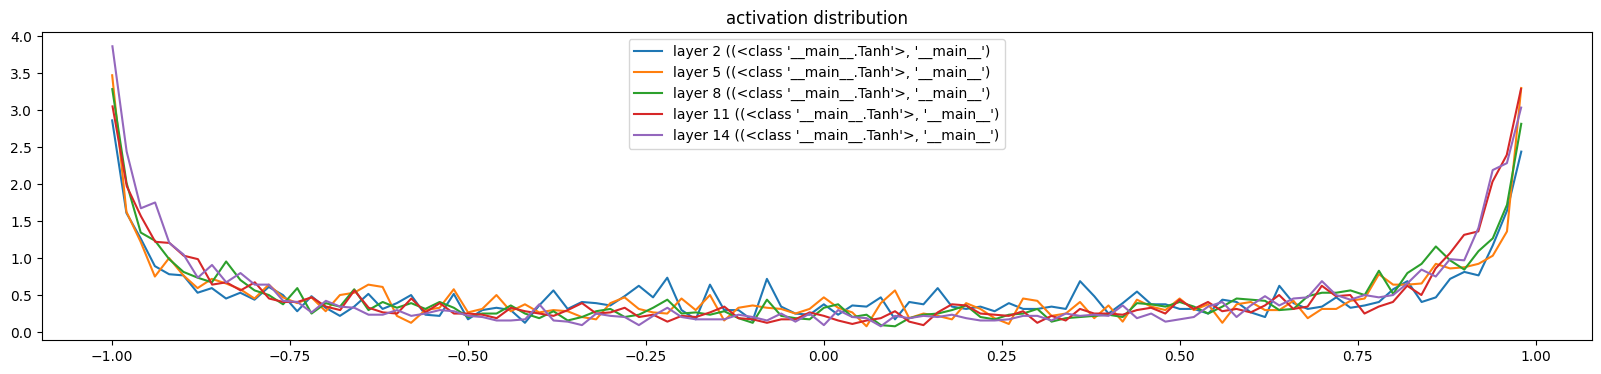

In [ ]:
# visualization histograms
plt.figure(figsize=(20, 4)) # width and height of the figure
legends = []
for i, layer in enumerate(layers[:-1]): # note : exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s) : mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))    
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__,__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 2 (      Tanh) : mean -0.000000, std 3.419895e-03
layer 5 (      Tanh) : mean -0.000000, std 3.286312e-03
layer 8 (      Tanh) : mean +0.000000, std 3.268489e-03
layer 11 (      Tanh) : mean -0.000000, std 3.537778e-03
layer 14 (      Tanh) : mean -0.000000, std 3.845714e-03


Text(0.5, 1.0, 'gradient distribution')

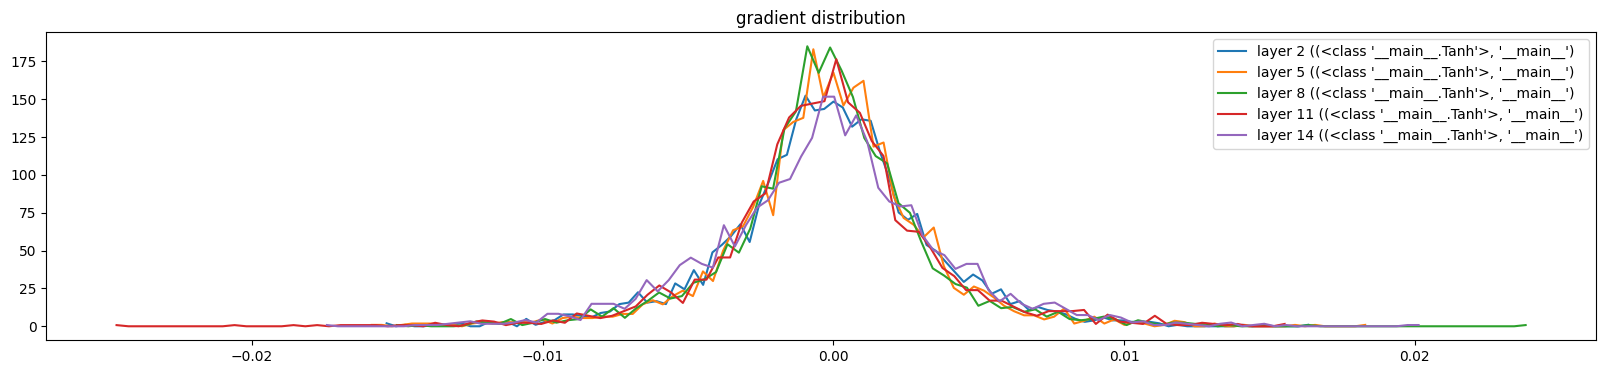

In [ ]:
# visualization histograms
plt.figure(figsize=(20, 4)) # width and height of the figure
legends = []
for i, layer in enumerate(layers[:-1]): # note : exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s) : mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))    
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__,__name__}')
plt.legend(legends);
plt.title('gradient distribution')


weight   (27, 10) | mean -0.000000 | std 1.496320e-02 | graduate ratio 1.370158e-02
weight  (30, 100) | mean +0.000084 | std 7.875953e-03 | graduate ratio 1.921666e-02
weight (100, 100) | mean +0.000060 | std 5.054002e-03 | graduate ratio 2.047483e-02
weight (100, 100) | mean -0.000086 | std 5.175930e-03 | graduate ratio 2.132119e-02
weight (100, 100) | mean +0.000044 | std 5.198809e-03 | graduate ratio 2.194954e-02
weight (100, 100) | mean -0.000013 | std 5.236910e-03 | graduate ratio 2.277906e-02
weight  (100, 27) | mean +0.000053 | std 9.171205e-03 | graduate ratio 2.776844e-02


Text(0.5, 1.0, 'weight gradient distribution')

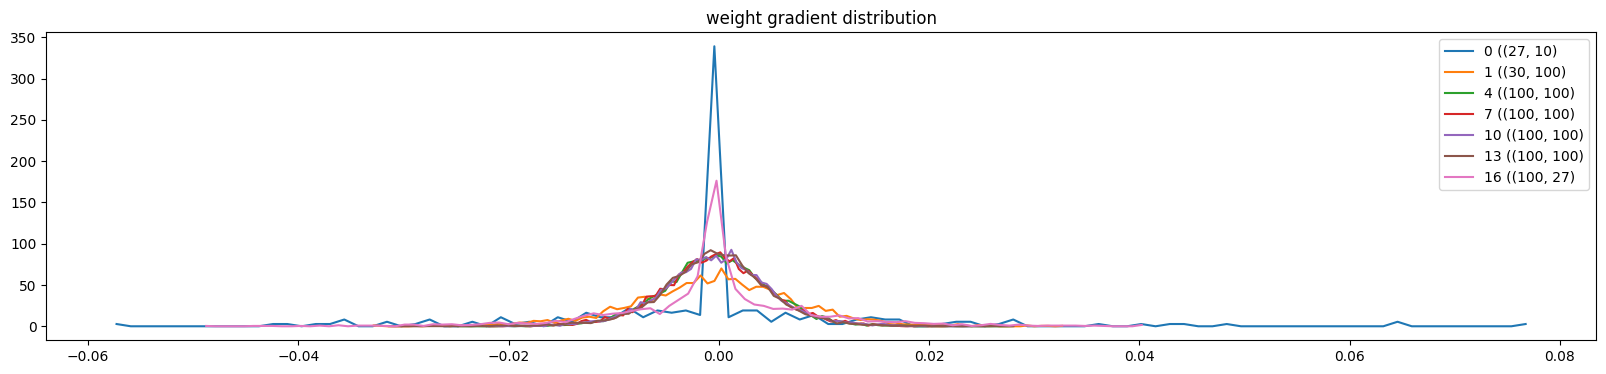

In [ ]:
# visualization histograms
plt.figure(figsize=(20, 4)) # width and height of the figure
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2 :
        print('weight %10s | mean %+f | std %e | graduate ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))    
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} ({tuple(p.shape)}')
plt.legend(legends);
plt.title('weight gradient distribution')


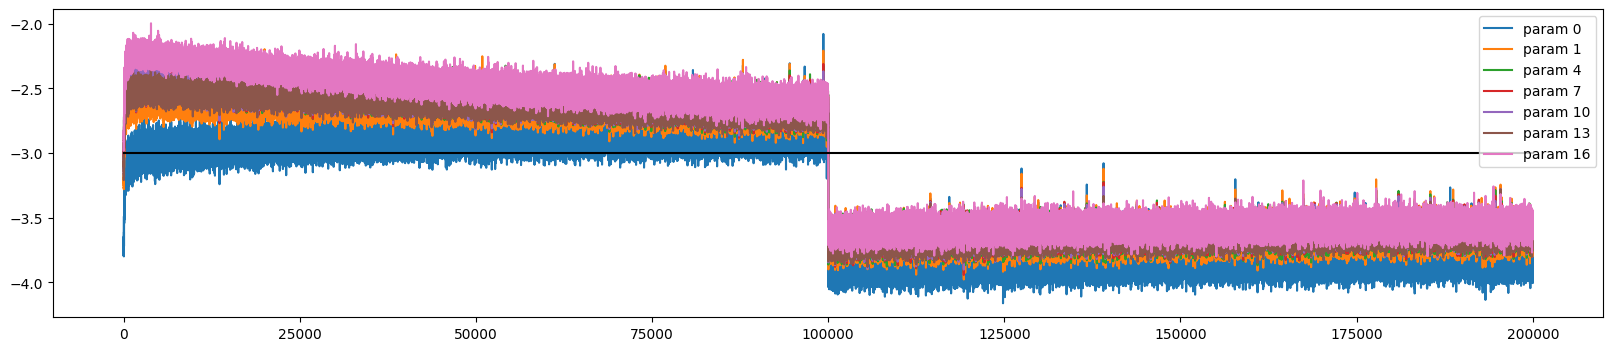

In [ ]:
plt.figure(figsize=(20, 4)) # width and height of the figure
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2 :
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);